# Video Detection Project


## The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
import numpy as np
import pickle
import cv2
import glob
import time
import os
%matplotlib inline

## Visualization

In [2]:
# Read picture from dataset
cars = glob.glob('dataset/vehicles/**/*.png',recursive=True)
notcars = glob.glob('dataset/non-vehicles/**/*.png',recursive=True)

print('Number of car images:', len(cars))
print('Number of not car images:', len(notcars))

Number of car images: 8792
Number of not car images: 8968


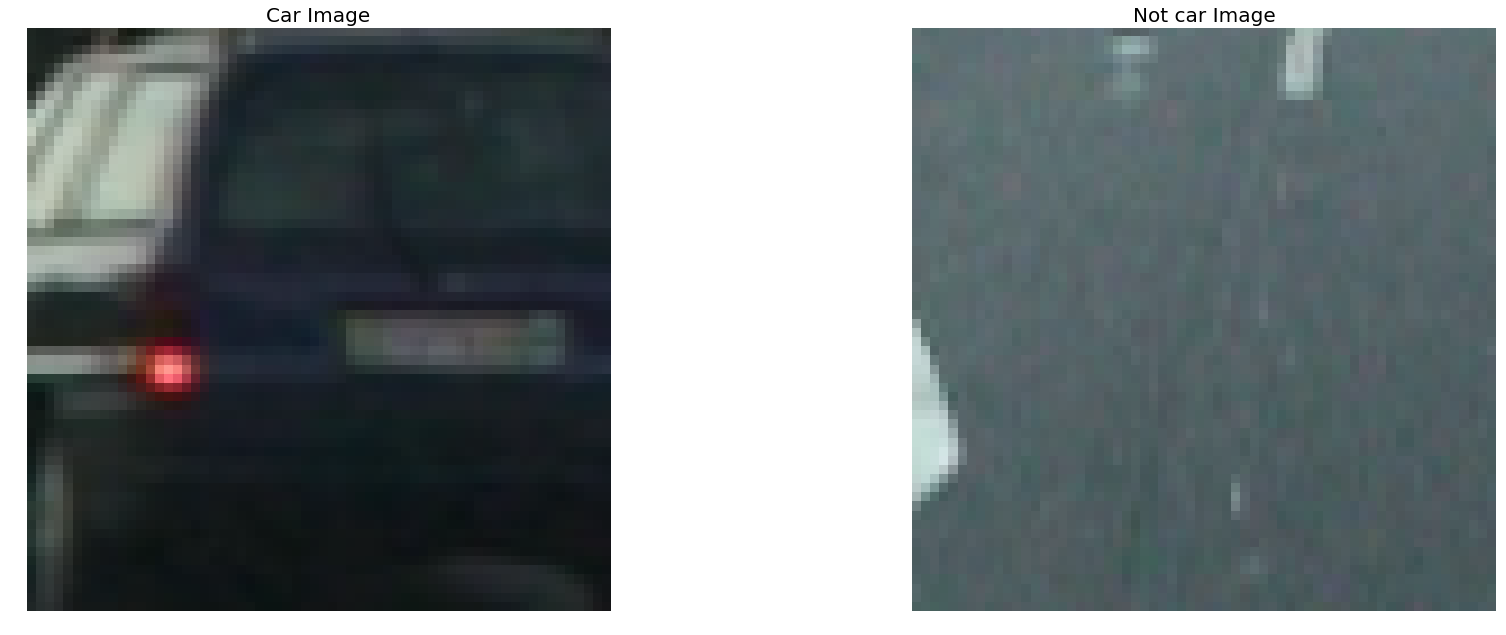

In [3]:
#Visualization
carimg=mpimg.imread(cars[np.random.randint(0, len(cars))])
notcarimg=mpimg.imread(notcars[np.random.randint(0, len(notcars))])
f,(ax1,ax2) = plt.subplots(1, 2,figsize=(24, 9))
plt.tight_layout()
ax1.imshow(carimg)
ax1.axis('off')
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(notcarimg)
ax2.axis('off')
ax2.set_title('Not car Image',  fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/car_not_car.png')

## Feature Extraction

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

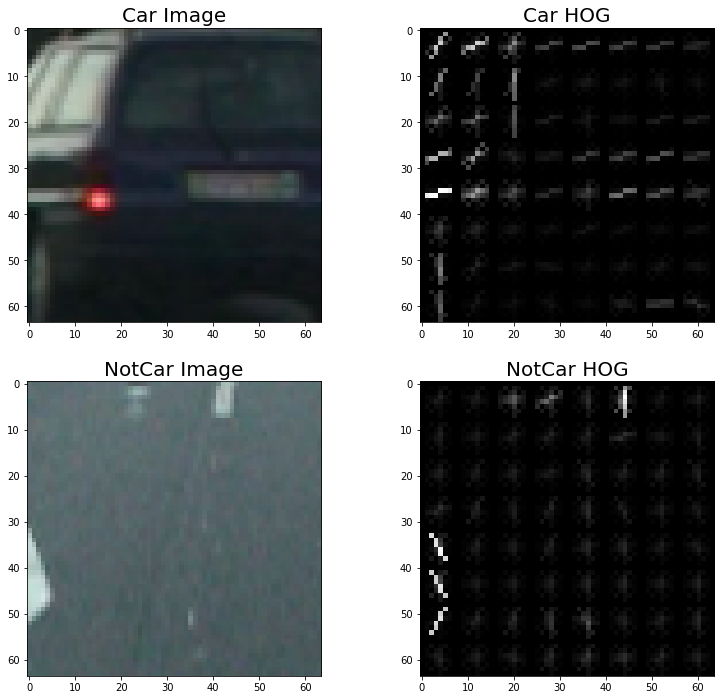

In [5]:
# Get hog image for tested image
_, car_hog = get_hog_features(carimg[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
_, notcar_hog = get_hog_features(notcarimg[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.imshow(carimg)
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG', fontsize=20)
ax3.imshow(notcarimg)
ax3.set_title('NotCar Image', fontsize=20)
ax4.imshow(notcar_hog, cmap='gray')
ax4.set_title('NotCar HOG', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/HOG_example.jpg')


In [6]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Training Classfier

In [8]:
color_space = 'YUV' 
# color_space = 'YCrCb' 
spatial_size = (32, 32) 
hist_bins = 32 
orient = 13
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" 
spatial_feat = True 
hist_feat = True 
hog_feat = True 
    
# Get the features of cars and noncars
car_features = extract_features(cars, color_space, spatial_size, hist_bins, orient, pix_per_cell, 
                                cell_per_block, hog_channel)

notcar_features = extract_features(notcars, color_space, spatial_size, hist_bins, orient, pix_per_cell, 
                                cell_per_block, hog_channel)


In [9]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X = np.nan_to_num(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Data normalization and randomize
X_Scaler = StandardScaler().fit(X)
X_scaled = X_Scaler.transform(X)
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=rand_state)
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
print("{} train items".format(len(X_train)))
print("{} test items".format(len(X_test)))
# training
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC: ', round(svc.score(X_test, y_test), 4))


14208 train items
3552 test items
Test Accuracy of SVC:  0.9893


## Sliding Window Search

In [10]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img 

# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
       
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []            
            for channel in range(feature_image.shape[2]):                
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))                 
        else:            
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                hog_features = np.ravel(hog_features)
       
    #8) Append features to list
        img_features.append(hog_features)
        
    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

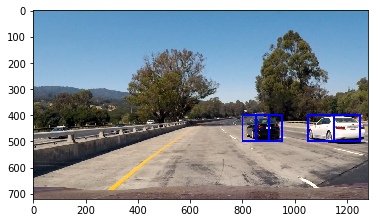

In [11]:
# Test
y_start_stop = [350, None]
hist_range = (0, 256)

image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Scale the image since its a .jpg
image = image.astype(np.float32)/255

# Search with three different window sizes
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(100, 100), xy_overlap=(0.5, 0.5))

# Get the found windows that match the features as list
hot_windows = search_windows(image, windows, svc, X_Scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)                       

# Draw the found windows that match the features in boxes
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()
# f.savefig('output_images/car_not_car.png')

## Find Cars

In [12]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    boxes = []

    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
          
    return draw_img, boxes
    

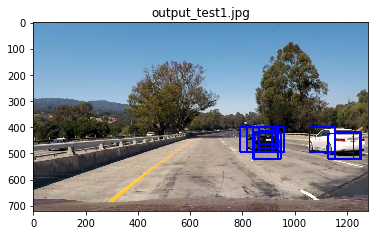

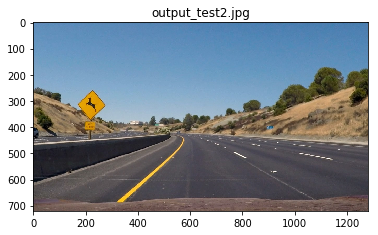

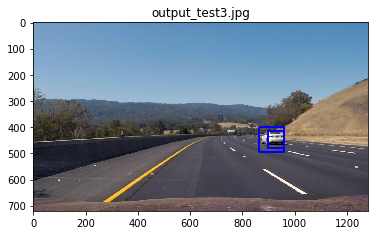

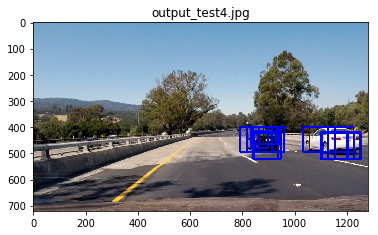

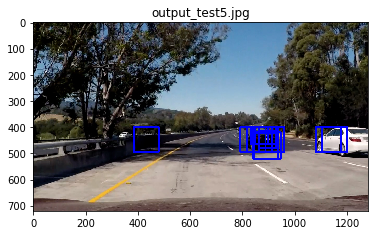

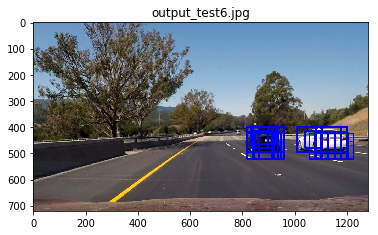

In [13]:
def Search_Pipeline(img):
    boxes = []
    ystart = 400
    ystop = 500 
    scale = 1.0
    _, bboxes1 = find_cars(img, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    scale = 1.3
    _, bboxes2 = find_cars(img, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    scale = 1.4
    _, bboxes3 = find_cars(img, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    scale = 1.6
    _, bboxes4 = find_cars(img, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    scale = 1.8
    _, bboxes5 = find_cars (img, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    scale = 2.0
    _, bboxes6 = find_cars (img, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    scale = 1.9
    _, bboxes7 = find_cars (img, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 656   
    scale = 1.5
    _, bboxes8 = find_cars(img, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    scale = 2.2
    _, bboxes9 = find_cars (img, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656
    scale = 3.0
    _, bboxes10 = find_cars (img, ystart, ystop, scale, svc, X_Scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) 

    boxes.extend(bboxes1)
    boxes.extend(bboxes2)
    boxes.extend(bboxes3)
    boxes.extend(bboxes4)
    boxes.extend(bboxes5)
    boxes.extend(bboxes6)
    boxes.extend(bboxes7)
    boxes.extend(bboxes8)
    boxes.extend(bboxes9)
    boxes.extend(bboxes10)
#     bboxes = []

    return boxes
    
    
test_images = os.listdir("./test_images/")
for image in test_images:
    img = mpimg.imread("./test_images/"+image)
    test_img = np.copy(img)    
    boxes = Search_Pipeline(img)
    img_out = draw_boxes(test_img, boxes, color=(0, 0, 255), thick=6)
    plt.imshow(img_out)
    plt.title('output_'+image)
    plt.show()       
    mpimg.imsave("output_images/""output_"+image, img_out)


## Heat Map

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

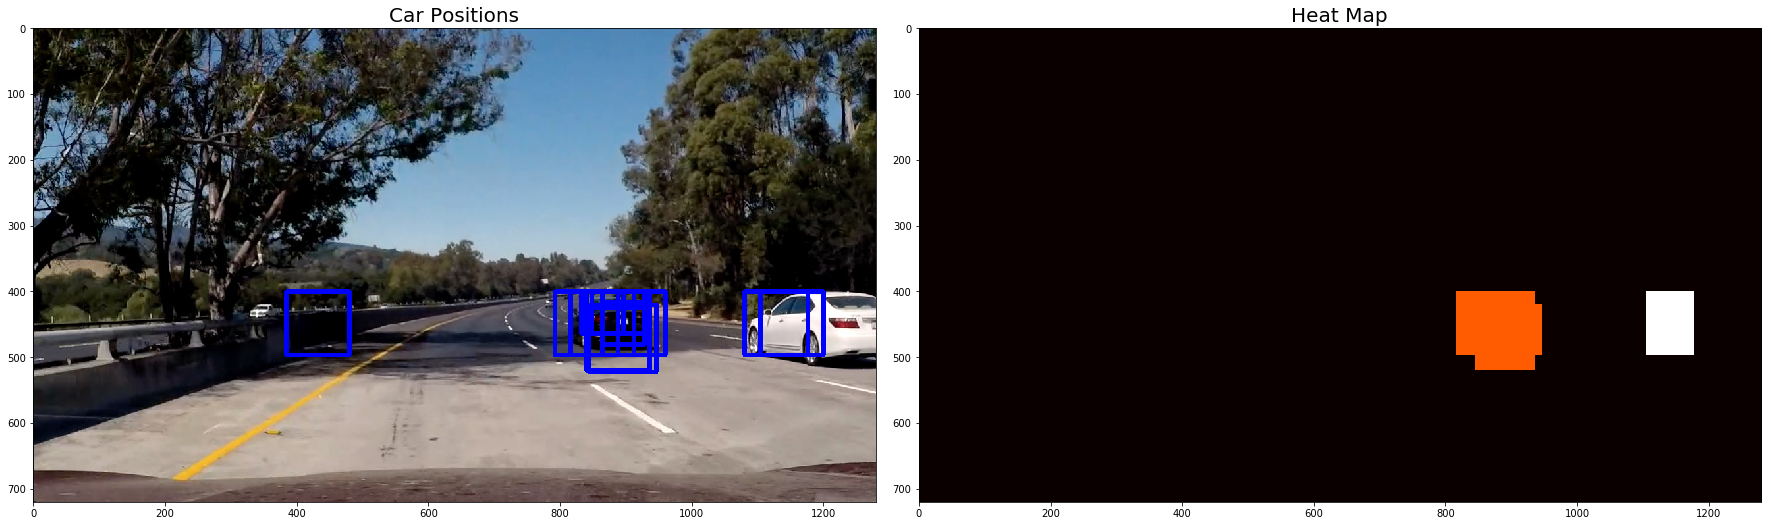

In [15]:
img = mpimg.imread('test_images/test5.jpg')
boxes = Search_Pipeline(img)
img_out = draw_boxes(img, boxes, color=(0, 0, 255), thick=6)
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat, boxes)
threshold = 1
heat= apply_threshold(heat, threshold)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(img, labels)

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_out)
ax1.set_title('Car Positions', fontsize=20)
ax2.imshow(labels[0], cmap='hot')
ax2.set_title('Heat Map', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('output_images/bboxes_and_heat.png')

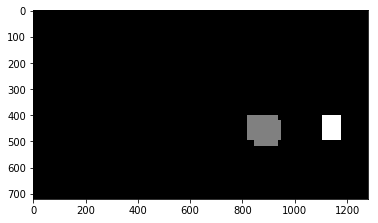

In [16]:
plt.imshow(labels[0], cmap='gray')
plt.show()

## Pipeline

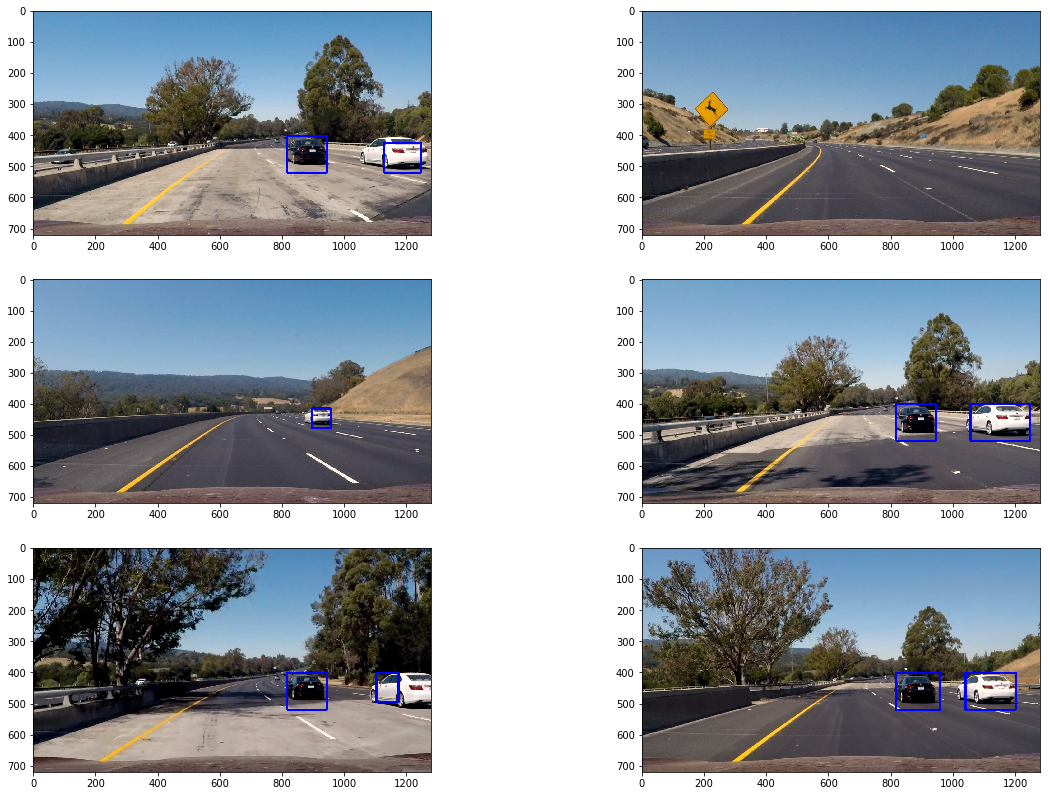

In [17]:
def pipeline(img):
    boxes = Search_Pipeline(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, boxes)
    threshold = 1
    heat = apply_threshold(heat, threshold)
    current_heatmap = np.clip(heat, 0, 255)
    history.append(current_heatmap)
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    output_img = draw_labeled_bboxes(np.copy(img), labels)

    return output_img

test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(20,14))
axs = axs.ravel()

for i, im in enumerate(test_images):
    history = deque(maxlen=3) 
    output = pipeline(mpimg.imread(im))
    axs[i].imshow(output)

## Video Output

In [18]:
history = deque(maxlen=3) 
video_output  = './output_images/test_video_output.mp4'
video_input  = VideoFileClip("test_video.mp4")
processed_video  = video_input.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/test_video_output.mp4
[MoviePy] Writing video ./output_images/test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:40<00:01,  1.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_video_output.mp4 

Wall time: 41.6 s


In [21]:
history = deque(maxlen=3) 
video_output2 = './output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_input2 = VideoFileClip("project_video.mp4")
processed_video2 = video_input2.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_video2.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_output.mp4
[MoviePy] Writing video ./output_images/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:47<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_output.mp4 

Wall time: 22min 48s


In [22]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))